In [1]:
import config
import os, numpy as np, pandas, sklearn, scipy.signal as signal
import mido
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## NN libs
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
import keras
from keras import regularizers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.optimizers import SGD, Adam
from keras.layers import Input, Dense, Activation, Conv1D, Conv2D, Dropout, Flatten
from keras.layers import Conv2DTranspose, Reshape, MaxPooling2D, UpSampling2D, UpSampling1D, MaxPooling1D
from keras.layers import LocallyConnected1D, LocallyConnected2D
from keras.layers import Input, LSTM, RepeatVector
from keras.models import Model
from keras.callbacks import TensorBoard

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# local libs
import config, models, functions
from data import data, midi, midi_generators as g
from utils import io, models_io, utils

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_instances = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]



In [18]:
context = data.init()
n = 30
multiTrack = False
context, x_train, labels = data.import_data(data.init(), n, multiTrack=multiTrack)

Setting up params

max min f 25.0 0.1
 >> Context(max_t=10.0, dt=0.02, n_instances=500, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
Setting up params

max min f 25.0 0.1
 >> Context(max_t=10.0, dt=0.02, n_instances=500, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
Importing midi-data

 [INFO] : 
 |  reading file: ../datasets/examples/01 16th Snare.mid
 [INFO] : 
 |  reading file: ../datasets/examples/01 8th Cym.mid
 [INFO] : 
 |  reading file: ../datasets/examples/01 8th Hat.mid
 [INFO] : 
 |  reading file: ../datasets/examples/02 8th Cym.mid
 [INFO] : 
 |  reading file: ../datasets/examples/114_LetsDance_DavidBowie1.mid
 [INFO] : 
 |  reading file: ../datasets/examples/127_SweetChildOMine_GunsAndRoses1.mid
 [INFO] : 
 |  reading file: ../datasets/examples/92_GiveItAway_TheRedHotChiliPeppers.mid
 [INFO] : 
 |  reading file: ../datasets/examples/94_Creep_Radiohead2.mid
 [INFO] : 
 |  reading file: ../datasets/examples/bossa 1.mid
 [INFO] : 
 |  readi

In [5]:
x_train.shape

(20, 500, 1)

In [6]:
x_test = x_train

y_train = x_train[:,:-1,:]
z_train = x_train[:,1:,:]
x_train = y_train

encoder_input_data = y_train # english sentences
decoder_input_data = y_train # french sentences (copy)
decoder_target_data = z_train # french sentences, next timestep

print(x_train.shape, y_train.shape, z_train.shape)

(20, 499, 1) (20, 499, 1) (20, 499, 1)


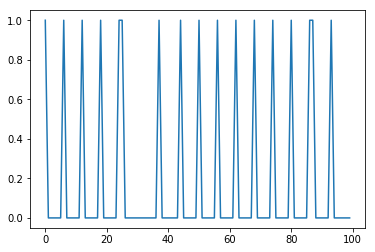

In [8]:
plt.plot(x_train[0,:100])

In [9]:
n_samples = x_train[0]
input_shape = x_train.shape[1:] # shape of a single sample
output_shape = y_train.shape[1:] # shape of a single sample
# output_length = y_train.shape[1:][0]
hidden_layer_length = 10
input_shape

(499, 1)

In [10]:
output_shape

(499, 1)

In [11]:
num_encoder_tokens = x_train.shape[-1]
num_decoder_tokens = y_train.shape[-1]
latent_dim = 64

In [12]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
_, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='sigmoid')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 1)      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 1)      0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 64), (None,  16896       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 64), ( 16896       input_2[0][0]                    
                                                                 lstm_1[0][1]                     
          

In [13]:
# encoder.summary()
# decoder.summary()

In [14]:
metrics = ['accuracy','mse','binary_crossentropy'] # sparse_categorical_accuracy
loss = 'binary_crossentropy'# binary_crossentropy categorical_crossentropy sparse_categorical_crossentropy
optimizer = 'rmsprop' # adam adadelta rmsprop nadam
# keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
model.compile(optimizer=optimizer, loss=loss, metrics=['mse', 'mae'])#, metrics=metrics)

In [15]:
batch_size = 4
# n epochs = n iterations over all the training data
epochs = 6

In [16]:
callbacks = []
callbacks = [TensorBoard(log_dir=config.tmp_log_dir)]
vs = 1/6
# model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[TensorBoard(log_dir=config.tmp_log_dir)])
history = model.fit([x_train,y_train], z_train, epochs=epochs, batch_size=batch_size,
          validation_split=vs, callbacks=callbacks)

Train on 16 samples, validate on 4 samples
Epoch 1/6
16/16 [==============================] - 3s 164ms/step - loss: 0.6604 - mean_squared_error: 0.2337 - mean_absolute_error: 0.4831 - val_loss: 0.5628 - val_mean_squared_error: 0.1853 - val_mean_absolute_error: 0.4298
Epoch 2/6
16/16 [==============================] - 2s 136ms/step - loss: 0.2846 - mean_squared_error: 0.0814 - mean_absolute_error: 0.1790 - val_loss: 0.1187 - val_mean_squared_error: 0.0238 - val_mean_absolute_error: 0.0662
Epoch 3/6
16/16 [==============================] - 2s 138ms/step - loss: 0.1881 - mean_squared_error: 0.0417 - mean_absolute_error: 0.0849 - val_loss: 0.1143 - val_mean_squared_error: 0.0235 - val_mean_absolute_error: 0.0551
Epoch 4/6
16/16 [==============================] - 2s 133ms/step - loss: 0.1775 - mean_squared_error: 0.0406 - mean_absolute_error: 0.0767 - val_loss: 0.1169 - val_mean_squared_error: 0.0237 - val_mean_absolute_error: 0.0619
Epoch 5/6
16/16 [==============================] - 2s 135

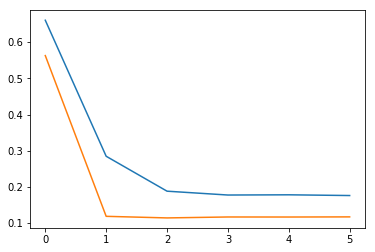

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# Inferencing

model.predict() requires 2 inputs: english sentences + french sentences

In [110]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [111]:
encoder_model.summary()
decoder_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, None, 4)           0         
_________________________________________________________________
lstm_5 (LSTM)                [(None, 64), (None, 64),  17664     
Total params: 17,664
Trainable params: 17,664
Non-trainable params: 0
_________________________________________________________________
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, None, 4)      0                                            
__________________________________________________________________________________________________
input_15 (InputLayer)           (None, 64)           0                                            
_______________________________________

In [119]:
def decode_sequence(input_seq, encoder_model, decoder_model):
    max_decoder_seq_length = 500
    
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = []
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        print(output_tokens.shape)

        output_ = output_tokens[0, -1, :] # identity in case of 1 batch?
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        # sampled_char = sampled_token_index # reverse_target_char_index[sampled_token_index]
        decoded_sentence.append(output_)

        # Exit condition: either hit max length
        # or find stop character.
        if len(decoded_sentence) >= max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        # target_seq[0, 0, :] = output_
        target_seq[0, 0, :] = output_


        # Update states
        states_value = [h, c]

    return np.stack(decoded_sentence)

In [120]:
result = decode_sequence(x_train[:1], encoder_model, decoder_model)
result.shape

(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)
(1, 1, 4)


(500, 4)

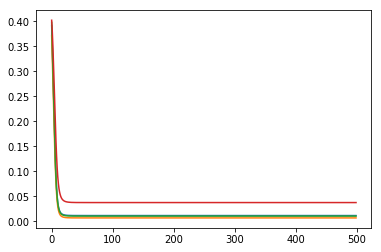

In [117]:
plt.plot(result)

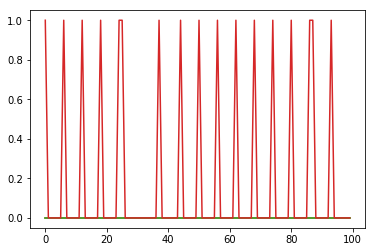

In [115]:
plt.plot(x_train[0,:100,:])

In [116]:
result.shape

(500, 4)

In [100]:
mid = midi.decode_track(context, result)
dn = config.dataset_dir
# io.export_midifile(mid, dn + 'song_seq-seq.mid')

 [INFO] : 
 |  len, max_t
 |  10.424999999999955
 |  10.0


## Alt
Without teacher forcing

In [ ]:
from keras.layers import Lambda
from keras import backend as K

# The first part is unchanged
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
_, state_h, state_c = encoder(encoder_inputs)
states = [state_h, state_c]

# Set up the decoder, which will only process one timestep at a time.
decoder_inputs = Input(shape=(1, num_decoder_tokens))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
# output will be a probability distribution over the vectors
decoder_dense = Dense(num_decoder_tokens, activation='softmax')

all_outputs = []
inputs = decoder_inputs
max_decoder_seq_length = 100
for _ in range(max_decoder_seq_length):
    # Run the decoder on one timestep
    outputs, state_h, state_c = decoder_lstm(inputs,
                                             initial_state=states)
    outputs = decoder_dense(outputs)
    # Store the current prediction (we will concatenate all predictions later)
    all_outputs.append(outputs)
    # Reinject the outputs as inputs for the next loop iteration
    # as well as update the states
    inputs = outputs
    states = [state_h, state_c]

# Concatenate all predictions
decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)

# Define and compile model as previously
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

In [ ]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

# Prepare decoder input data that just contains the start character
# Note that we could have made it a constant hard-coded in the model
decoder_input_data = np.zeros((x_train.shape[0], 1, num_decoder_tokens))

# Train model as previously
model.fit([x_train,y_train], z_train, epochs=10, batch_size=batch_size,
          validation_split=0.2, callbacks=callbacks)

In [ ]:
x_test.shape

In [ ]:
# x_test, y_test = gen_xy_sin_to_f(3, f=2)

In [ ]:
results = model.predict([x_test,x_test])
results.shape

In [ ]:
# the 'true' results
i = 0
selection = int(x_test.shape[1] * 1)
full = np.concatenate([x_test[i,-selection:],y_test[i]])
n3 = full.shape[0]
plt.plot(np.arange(n3) / n3 * dt, full)

In [ ]:
# predicted results
i = 0
full = np.concatenate([x_test[i,-selection:],results[i]])
n3 = full.shape[0]
plt.plot(np.arange(n3) / n3 * dt, full)

In [ ]:
i = 2
selection = int(x_test.shape[1] * 1)
full = np.concatenate([x_test[i,-selection:],results[i]])
n3 = full.shape[0]
plt.plot(np.arange(n3) / n3 * dt, full)

In [ ]:
i = 0
selection = 1
full = np.concatenate([x_test[i,-selection:],results[i]])
n3 = full.shape[0]
plt.plot(np.arange(n3) / n3 * dt, full)